# 🤖 RoboChat  

**RoboChat** is an AI-powered assistant designed to help students, hobbyists, and engineers explore **electronics, robotics, and IoT components**.  
It can:  
- Answer technical questions about microcontrollers, sensors, and modules using its **local knowledge base**.  
- Retrieve real-time data about **component availability and pricing** using **web search + store lookup tools**.  
- Act as an interactive tutor, guiding users through projects with step-by-step explanations.  

With **retrieval-augmented generation (RAG)** and **web integration**, RoboChat ensures you get both **accurate specifications** and **actionable buying options** in one place.  


### 📄 PDF → JSON → Text Conversion Pipeline  

In this section, robotics component datasheets are processed through a multi-step pipeline:  

1. **PDF Text Extraction** – Using `PyMuPDF`, raw text is extracted from each page of the PDF.  
2. **Structured JSON Parsing** – The extracted text is parsed by an LLM into a predefined schema for each component category (e.g., control boards, sensors, motors). Missing fields are kept empty, while extra useful fields can be added.  
3. **JSON Storage** – Each component is saved as a structured JSON file for consistency and reusability.  
4. **JSON → Text Conversion** – The JSON files are recursively converted into clean, human-readable text. This step ensures the information is easy to read while preserving hierarchical structure.  
5. **Final Output** – The processed text files are stored in an organized folder, ready for downstream tasks like retrieval-augmented generation (RAG), training, or search indexing.  

This pipeline ensures that unstructured datasheets are transformed into structured and accessible knowledge for AI applications.  

In [ ]:
%%capture
pip install PyMuPDF python-dotenv

In [128]:
import json
from dotenv import load_dotenv
import os

load_dotenv()

with open("schemas.json", "r") as f:
    schemas = json.load(f)

print(schemas)

{'Control Board': {'component_name': '', 'category': '', 'manufacturer': '', 'sku': '', 'description': '', 'application_examples': [], 'related_products': [], 'specifications': {'main_processor': '', 'memory_main': {'flash': '', 'sram': '', 'eeprom': ''}, 'secondary_processor': '', 'memory_secondary': {'flash': '', 'sram': '', 'eeprom': ''}, 'operating_voltage': '', 'input_voltage_recommended': '', 'input_voltage_limits': '', 'operating_temperature': '', 'digital_io_pins': '', 'pwm_pins': '', 'analog_input_pins': '', 'dc_current_per_io_pin': '', 'flash_memory_for_bootloader': ''}, 'power': {'vin_max': '', 'vusb_max': '', 'consumption': ''}, 'pinout': {'analog_pins': {}, 'digital_pins': {}, 'power_pins': {}}, 'certifications': [], 'getting_started': {'ide': '', 'cloud_editor': ''}, 'sample_sketches': '', 'online_resources': [], 'datasheet_url': '', 'company_info': {'name': '', 'address': ''}, 'revision_history': [], 'languages_available': [], 'source_document': '', 'example_code': [{'co

In [ ]:
import fitz
import json
import os
from openai import OpenAI

client = OpenAI(
    base_url="https://router.huggingface.co/v1",
    api_key=os.getenv("HF_TOKEN"),
)

# Hybrid schemas for categories


def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text("text") + "\n"
    return text.strip()

def extract_json_with_llm(raw_text, category):
    schema = json.dumps(schemas[category], indent=2)
    prompt = f"""
    You are a technical parser for robotics components.
    Extract information from the text and fill in this JSON template for a {category}.
    You are free to add more field in the JSON template if you think they are useful about the component. Don't remove any fields, just add if needed.
    Focus on the component's specifications table.
    If can't find the data of one of the fields in the document, leave them empty.
    Ensure the output is ONLY the JSON object and nothing else.

    {schema}

    Source text:
    {raw_text}
    """
    resp = client.chat.completions.create(
        model="openai/gpt-oss-120b:fireworks-ai",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return json.loads(resp.choices[0].message.content)

def process_folder(folder_path, category):
    for file in os.listdir(folder_path):
        if file.endswith(".pdf"):
            pdf_path = os.path.join(folder_path, file)
            raw_text = extract_text_from_pdf(pdf_path)
            json_data = extract_json_with_llm(raw_text, category)
            json_filename = file.replace(".pdf", ".json")
            with open(os.path.join(folder_path, json_filename), "w") as f:
                json.dump(json_data, f, indent=2)
            print(f"Processed {file}")

process_folder("/content/boards", category="Control Board")
process_folder("/content/sensor", category="Sensors")
process_folder("/content/motor", category="Motor")
process_folder("/content/motor driver", category="Motor Driver")
process_folder("/content/module", category="Communication Module")
process_folder("/content/modules2", category="Other Module")
process_folder("/content/power", category="Power Component")
process_folder("/content/displays", category="Displays")

In [6]:
import os
import json

json_folder = "jsons"
output_folder = "rag_text"
output_format = "txt"


os.makedirs(output_folder, exist_ok=True)

def json_to_text(data, indent=0):
    """Recursively convert JSON dict/list to human-readable text."""
    text_lines = []
    indent_str = "  " * indent

    if isinstance(data, dict):
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                text_lines.append(f"{indent_str}{key}:")
                text_lines.extend(json_to_text(value, indent + 1))
            else:
                text_lines.append(f"{indent_str}{key}: {value}")
    elif isinstance(data, list):
        for idx, item in enumerate(data, start=1):
            if isinstance(item, (dict, list)):
                text_lines.append(f"{indent_str}- Item {idx}:")
                text_lines.extend(json_to_text(item, indent + 1))
            else:
                text_lines.append(f"{indent_str}- {item}")
    else:
        text_lines.append(f"{indent_str}{data}")

    return text_lines

for filename in os.listdir(json_folder):
    if filename.lower().endswith(".json"):
        file_path = os.path.join(json_folder, filename)

        # Load JSON
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                json_data = json.load(f)
            except json.JSONDecodeError as e:
                print(f"Error reading {filename}: {e}")
                continue

        # Convert to text
        text_lines = json_to_text(json_data)
        text_content = "\n".join(text_lines)

        # Get component name or use filename
        component_name = json_data.get("component_name", os.path.splitext(filename)[0])
        safe_name = component_name.replace(" ", "_").replace("/", "_")

        # Save to output file
        out_path = os.path.join(output_folder, f"{safe_name}.{output_format}")
        with open(out_path, "w", encoding="utf-8") as out_file:
            out_file.write(text_content)

        print(f"Converted {filename} → {out_path}")

print("\nAll JSON files converted successfully!")


Converted 0a-esp8266ex_datasheet_en.json → rag_text/ESP8266EX.txt
Converted LG-18650-MG1.json → rag_text/18650_MG1_2900mAh_Lithium_Ion_Battery.txt
Converted esp-wroom-32_datasheet_en.json → rag_text/ESP-WROOM-32.txt
Converted lm340.json → rag_text/LM7805.txt
Converted Active-Buzzer-Module-Datasheet.json → rag_text/5V_Buzzer_Module.txt
Converted voltage-sensor.json → rag_text/Voltage_Sensor___170640.txt
Converted NEMA08-03_Datasheet_2021-07-23.json → rag_text/NEMA_8_Stepper_Motor_NEMA08-03.txt
Converted ABX00087-datasheet.json → rag_text/Arduino®_UNO_R4_WiFi.txt
Converted SR501 Motion Sensor.json → rag_text/HC-SR501_Passive_Infrared_(PIR)_Motion_Sensor.txt
Converted HC-SR04-Ultrasonic.json → rag_text/HC-SR04_Ultrasonic_Sensor_Module.txt
Converted Datasheet.json → rag_text/HC-05_Bluetooth_Module.txt
Converted raspberry-pi-4-datasheet.json → rag_text/Raspberry_Pi_4_Model_B.txt
Converted Soldered_333099-3395096.json → rag_text/Display_OLED_I2C_0.96"_SSD1306.txt
Converted lcd016n002bcfhet.j

### 📂 Document Loading, Splitting & Vector Store Ingestion  

This section prepares the processed text files for retrieval by converting them into structured **LangChain Documents** with metadata and embeddings:  

1. **Metadata Extraction** – Key fields such as `component_name`, `category`, `manufacturer`, and `datasheet_url` are automatically extracted from the text. Missing values are filled with sensible defaults.  
2. **Document Creation** – Each `.txt` file is loaded either with a `TextLoader` or manually into a `Document` object, enriched with extracted metadata for better indexing and search.  
3. **Text Chunking** – Documents are split into overlapping chunks using `RecursiveCharacterTextSplitter` to optimize retrieval. Each chunk is tagged with its component name and category for context.  
4. **Embeddings Generation** – Using the **sentence-transformers/all-MiniLM-L6-v2** model, embeddings are created for all chunks, enabling semantic similarity search.  
5. **Vector Store Storage** – The chunked documents and their embeddings are inserted into a **Chroma Cloud vector database**, organized under the `Rag-docs` collection. This makes the dataset ready for retrieval-augmented generation (RAG) pipelines.  

With this step, the raw component datasheets are transformed into a **searchable, chunked, and semantically indexed knowledge base** that can be queried efficiently by AI models.  

In [ ]:
%%capture
!pip install langchain langchain_chroma langsmith langchain_community langchain_huggingface pypdf unstructured langchain_core "langchain[experimental]" lark langchain-openai

In [7]:
import os
from langchain_community.document_loaders import TextLoader
from langchain.schema import Document

# Folder where your text files are stored
TXT_FOLDER = "rag_text"

def extract_metadata_from_content(content):
    """
    Extracts metadata from a component text file.
    Assumes metadata keys like 'component_name:' appear at the start of a line.
    """
    metadata = {}
    
    # Define the metadata fields we want to extract
    metadata_fields = [
        "component_name",
        "category", 
        "manufacturer",
        "datasheet_url",
        "sku",
        "source_document"
    ]
    
    for line in content.split("\n"):
        line = line.strip()
        if not line or ":" not in line:
            continue
            
        # Split only on first colon to handle URLs in values
        key, value = line.split(":", 1)
        key = key.strip().lower().replace(" ", "_")  # normalize key
        value = value.strip()

        # Match keys we're interested in
        if key in metadata_fields:
            metadata[key] = value

    return metadata

def load_docs_with_metadata(folder_path):
    all_docs = []
    
    for file_name in os.listdir(folder_path):
        if not file_name.endswith(".txt"):
            continue

        file_path = os.path.join(folder_path, file_name)
        
        # Use TextLoader for text files
        loader = TextLoader(
            file_path=file_path,
            encoding='utf-8'
        )
        
        try:
            docs = loader.load()
            
            # TextLoader typically returns one document per file
            if docs:
                doc = docs[0]
                content = doc.page_content
                
                # Extract metadata from content
                metadata = extract_metadata_from_content(content)
                
                # Fallbacks if metadata missing
                if "component_name" not in metadata:
                    metadata["component_name"] = os.path.splitext(file_name)[0].replace("_", " ")
                if "category" not in metadata:
                    metadata["category"] = "Unknown"
                
                # Add source file info
                metadata["source"] = file_name
                metadata["start_index"] = 0
                
                # Update document metadata
                doc.metadata.update(metadata)
                all_docs.append(doc)
                    
        except Exception as e:
            print(f"Error loading {file_name}: {str(e)}")
            continue

    return all_docs

# Alternative simpler approach if you want more control:
def load_docs_with_metadata_simple(folder_path):
    """
    Simpler approach that loads text files and creates Documents manually
    """
    all_docs = []
    
    for file_name in os.listdir(folder_path):
        if not file_name.endswith(".txt"):
            continue

        file_path = os.path.join(folder_path, file_name)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            
            # Extract metadata from content
            metadata = extract_metadata_from_content(content)
            
            # Fallbacks if metadata missing
            if "component_name" not in metadata:
                metadata["component_name"] = os.path.splitext(file_name)[0].replace("_", " ")
            if "category" not in metadata:
                metadata["category"] = "Unknown"
                
            metadata["source"] = file_name
            metadata["start_index"] = 0
            
            # Create Document
            doc = Document(
                page_content=content,
                metadata=metadata
            )
            all_docs.append(doc)
                
        except Exception as e:
            print(f"Error loading {file_name}: {str(e)}")
            continue
    
    return all_docs

# Load and display a sample
documents = load_docs_with_metadata(TXT_FOLDER)
print(f"Loaded {len(documents)} documents")
if documents:
    print("\nSample document content (first 200 chars):")
    print(documents[0].page_content[:200])
    print("\nSample metadata:")
    print(documents[0].metadata)

Loaded 81 documents

Sample document content (first 200 chars):
component_name: LTC4056-4.2
category: Power Component
sub_category: Li‑Ion Battery Charger Controller
manufacturer: Linear Technology Corporation
sku: 405642f
description: Low‑cost, single‑cell consta

Sample metadata:
{'source': 'LTC4056-4.2.txt', 'component_name': 'LTC4056-4.2', 'category': 'Power Component', 'manufacturer': 'Linear Technology Corporation', 'sku': '405642f', 'datasheet_url': 'https://www.linear.com/docs/4056.pdf', 'source_document': 'LTC4056-4.2 datasheet', 'start_index': 0}


In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150, add_start_index=True, length_function=len, separators=["\n\n", "\n", " ", ""])
final_chunks = []
for chunk in text_splitter.split_documents(documents):
    component_name = chunk.metadata["component_name"]
    category = chunk.metadata["category"]
    chunk.page_content = f"Component: {component_name}\nCategory: {category}\n\n{chunk.page_content}"
    final_chunks.append(chunk)


print(len(final_chunks))

261


In [10]:
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-MiniLM-L6-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

/Users/os/Desktop/Robotics-RAG/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import os
import chromadb
from langchain_chroma import Chroma

client = chromadb.HttpClient(
  ssl=True,
  host='api.trychroma.com',
  tenant=os.getenv('TENANT'),
  database=os.getenv('DATABASE'),
  headers={
    'x-chroma-token': os.getenv('CHROMA')
  }
)
# Use LangChain's Chroma wrapper with the cloud client
vectorstore = Chroma(
    client=client,
    collection_name="Rag-docs",
    embedding_function=embeddings
)

In [18]:
vectorstore.add_documents(
    collection_name='Rag-docs',
    documents=final_chunks,
    )

['04cd6382-d858-4455-bfd7-b0411ad32bcb',
 'fdac54e4-ff2c-477d-9ef5-e47238ea379d',
 '49598e9b-6c0d-4a45-a84d-b19ef6342ad9',
 'e8685e6a-ee59-45b3-8690-7252e42e6e63',
 'c3d02863-2326-41fd-b8a7-440d8ff006ee',
 'b0ec1026-0844-4999-b883-4845066d716f',
 '5a1ecd31-a24b-4033-8aab-7f91f3043b7b',
 '83eec29e-07c2-406f-ac13-a9008badd61a',
 'b7640934-e8a7-4dd2-9336-eb5d7ce90eee',
 '93abb469-6df5-43e0-a52e-276d766a85f7',
 'c8fc4a33-8b59-4ccd-8510-ae831293b32d',
 '69721bdd-1ab8-43cc-94d0-f52b114eb159',
 'fe99071f-0e03-4213-8c5c-645074fd6bb2',
 '99077f1a-2a2a-4ed1-a4bd-6bb286c9500b',
 'f3022a87-e86b-4d60-bde2-f589a261656a',
 '7e80df0c-ffbb-43e1-8812-d21aaa7e674b',
 '7bb360cb-5ed6-4692-a849-18397452dd9f',
 'e8027110-bafb-400c-9d59-1a40f47bc6bf',
 '7b7e52dd-979e-472e-9bcb-2a3aa88ad5c8',
 '52cfda24-eb22-4fb3-a185-5733cdaa5a3c',
 'af579f13-aac1-4390-ae0e-c4e5f64295c8',
 '1e06314c-2c12-40a3-9a54-032b06868271',
 '7953773e-5ced-45a3-9351-f9981a270f98',
 '2232fa19-ac6e-4152-b4db-c0b797684989',
 '8714ac39-1a77-

In [36]:
vectorstore.similarity_search("arduino")

[Document(id='5874880b-a71e-4c1a-8fea-8bca944565ea', metadata={'category': 'Control Board', 'component_name': 'Arduino Mega 2560 Rev3', 'seq_num': 1, 'start_index': 0, 'sku': 'A000067', 'datasheet_url': '', 'manufacturer': 'Arduino S.r.l.', 'source': 'A000067-datasheet.json', 'source_document': 'User Manual'}, page_content='Component: Arduino Mega 2560 Rev3\nCategory: Control Board\n\n{"component_name": "Arduino Mega 2560 Rev3", "category": "Control Board", "manufacturer": "Arduino S.r.l.", "sku": "A000067", "description": "Arduino\\u00ae Mega 2560 Rev3 is an exemplary development board dedicated for building extensive applications as compared to other maker boards by Arduino. The board accommodates the ATmega2560 microcontroller, which operates at a frequency of 16 MHz. The board contains 54 digital input/output pins, 16 analog inputs, 4 UARTs (hardware serial ports), a USB connection, a power jack, an ICSP header, and a reset button.", "application_examples": ["Robotics", "3D Printin

### 🤖 LLM Setup  

This step configures the **ChatOpenAI** wrapper to connect with Hugging Face’s endpoint using the `HF_TOKEN`.  
The chosen model, **gpt-oss-120b:fireworks-ai**, serves as the LLM backbone for reasoning and answering queries in the RAG pipeline.  

In [90]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    base_url="https://router.huggingface.co/v1",
    api_key=os.getenv('HF_TOKEN'),
    model_name="openai/gpt-oss-120b:fireworks-ai",
    )

### 🔧 Tools for Retrieval, Search & Store Lookup  

This section defines the **custom tools** that extend the RAG system with retrieval, search, and product-finding capabilities:  

1. **VectorDB Retrieval (`retrieval_tool`)** – Fetches relevant component data from the Chroma vector database using semantic similarity search.  
2. **Location Detection (`get_location_tool`)** – Uses free IP geolocation APIs to infer the user’s city, country, and coordinates.  
3. **Web Search (`search_stores_nearby`)** – Queries Google (via SerpAPI) to find nearby stores that sell a given electronic component.  
4. **Web Scraping (`scrape_product_details`)** – Extracts structured product details (title, price, availability, description) from store pages using BeautifulSoup and JSON-LD parsing.  
5. **Product Finder (`find_product_nearby_tool`)** – Combines search and scraping to return enriched product info from local stores based on the user’s location.  

Together, these tools allow the assistant not only to retrieve technical specs from the vector store but also to **find real-world availability and pricing** of robotics components in the user’s area.  

In [91]:
%%capture
!pip install langgraph langchain-tavily

In [92]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.agents import tool

In [93]:
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [94]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(
    max_results=3,
    topic="general",
)

In [95]:
@tool
def retrieval_tool(query: str) -> str:
  """Fetch data from VectorDB."""
  retriever = vectorstore.as_retriever(search_kwargs={"k": 6}, search_type="similarity")
  return retriever.invoke(query)

In [104]:
import requests
@tool
def get_location_tool() -> dict:
    """Fetch the user's location using IP address."""
    providers = [
        "https://ipwho.is/",
        "https://ipapi.co/json/",
    ]

    for url in providers:
        try:
            resp = requests.get(url, timeout=10)
            data = resp.json()

            # normalize response keys
            if "city" in data and "country_name" in data:
                return {
                    "city": data.get("city"),
                    "country": data.get("country_name"),
                    "lat": data.get("latitude"),
                    "lon": data.get("longitude")
                }
            elif "city" in data and "country" in data:
                return {
                    "city": data.get("city"),
                    "country": data.get("country"),
                    "lat": data.get("latitude") or data.get("lat"),
                    "lon": data.get("longitude") or data.get("lon")
                }
            elif "location" in data and isinstance(data["location"], dict):
                loc = data["location"]
                return {
                    "city": loc.get("city"),
                    "country": loc.get("country"),
                    "lat": loc.get("latitude"),
                    "lon": loc.get("longitude")
                }

        except Exception as e:
            print(f"Provider {url} failed: {e}")
            continue

    return {"error": "Could not detect location from any free provider"}


In [ ]:
from serpapi.google_search import GoogleSearch
import requests
from bs4 import BeautifulSoup
import re

def search_stores_nearby(component: str, location: str, max_results: int = 10):
    """
    Search for nearby stores selling a component using SerpAPI (Google Search).
    
    Args:
        component (str): The electronic component or item to search for.
        location (str): The location (city/area).
        max_results (int): Maximum number of results to return.
    
    Returns:
        list[dict]: Store search results with title, link, snippet, and source.
    """
    
    query = f"Buy {component} in {location['city']}, {location['country']}"
    
    params = {
        "engine": "google",
        "q": query,
        "hl": "en",
        "gl": "us",
        "api_key": os.getenv('SERPAPI_KEY'), 
    }
    
    search = GoogleSearch(params)
    results = search.get_dict()

    stores = []
    
    if "organic_results" in results:
        for item in results["organic_results"][:max_results]:
            stores.append({
                "title": item.get("title"),
                "link": item.get("link"),
                "snippet": item.get("snippet"),
                "source": item.get("source")
            })
    
    return stores


def clean_text(value: str) -> str:
    """Remove scripts, boilerplate, and weird junk from scraped text."""
    if not value:
        return None
    value = re.sub(r"\s+", " ", value) 
    value = re.sub(r"(BEGIN app block|Google Tag Manager.*|if lt IE.*)", "", value, flags=re.I)
    return value.strip() or None

def scrape_product_details(url: str):
    headers = {"User-Agent": "Mozilla/5.0"}
    try:
        response = requests.get(url, headers=headers, timeout=12)
    except Exception as e:
        return {"error": str(e), "url": url}

    soup = BeautifulSoup(response.text, "html.parser")

    # Remove scripts, styles, comments
    for tag in soup(["script", "style", "noscript"]):
        tag.extract()

    product = {
        "title": None,
        "price": None,
        "availability": None,
        "description": None
    }

    # 1. JSON-LD (best source)
    for script in soup.find_all("script", type="application/ld+json"):
        try:
            data = json.loads(script.string)
            if isinstance(data, dict) and data.get("@type") == "Product":
                product["title"] = product["title"] or clean_text(data.get("name"))
                product["description"] = product["description"] or clean_text(data.get("description"))
                if isinstance(data.get("offers"), dict):
                    product["price"] = product["price"] or clean_text(data["offers"].get("price"))
                    product["availability"] = product["availability"] or clean_text(data["offers"].get("availability"))
        except Exception:
            continue

    # 2. Itemprop microdata
    if not product["price"]:
        price_tag = soup.find(attrs={"itemprop": "price"})
        if price_tag:
            product["price"] = clean_text(price_tag.get("content") or price_tag.get_text())

    if not product["availability"]:
        avail_tag = soup.find(attrs={"itemprop": "availability"})
        if avail_tag:
            product["availability"] = clean_text(avail_tag.get("content") or avail_tag.get_text())

    # 3. Fallback selectors
    if not product["title"]:
        title_tag = soup.find("h1") or soup.find("title")
        if title_tag:
            product["title"] = clean_text(title_tag.get_text())

    if not product["description"]:
        desc = soup.find("meta", attrs={"name": "description"})
        if desc and desc.get("content"):
            product["description"] = clean_text(desc["content"])

    if not product["price"]:
        price_match = soup.find(string=re.compile(r"(\$|USD|EUR|EGP|LE)\s?\d+(\.\d{1,2})?"))
        if price_match:
            product["price"] = clean_text(price_match)

    if not product["availability"]:
        avail_match = soup.find(string=re.compile(r"(In Stock|Out of Stock|Available|Unavailable)", re.I))
        if avail_match:
            product["availability"] = clean_text(avail_match)


    return {k: clean_text(v) if isinstance(v, str) else v for k, v in product.items()}


In [127]:
@tool
def find_product_nearby_tool(component: str, location: dict) -> str:
    """Find the required product in stores near the user's location"""
    stores = search_stores_nearby(component, location)
    details = []
    for store in stores:
        details.append(scrape_product_details(store["link"]))
    return(details)

### 🤝 Agent Definition & Workflow  

This section defines the **Agent** that coordinates between the LLM and the custom tools using a `StateGraph`:  

1. **Agent State** – Tracks the conversation through a list of messages (`AnyMessage`) that get updated after each model response or tool call.  
2. **Graph Structure** –  
   - `llm` node → Calls the LLM with the conversation and system prompt.  
   - `action` node → Executes tool calls requested by the LLM.  
   - Conditional edges route execution back to `llm` if tool outputs are returned, creating a loop until no more actions are needed.  
3. **Tool Handling** – The agent checks tool names, invokes the correct one, and wraps the results in `ToolMessage` objects so the LLM can continue reasoning.  
4. **System Prompt** – Clearly defines the assistant’s behavior as a **robotics-focused engineer assistant** with strict multi-step reasoning:  
   - Step 1 → Query the vector store (`retrieval_tool`).  
   - Step 2 → Fall back to web search (`tavily_search_tool`) if needed.  
   - Step 3 → Always fetch the user’s location (`get_location_tool`).  
   - Step 4 → Always find real-world product availability (`find_product_nearby_tool`).  
   - Step 5 → Return detailed product offers (store, URL, price, availability).  

With this setup, the agent ensures every query follows a **consistent pipeline** that blends knowledge retrieval with live product lookup, making it both informative and actionable.  

In [99]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [102]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [121]:
prompt = """You are a smart engineer assistant specialized in robotics.

Follow these steps IN ORDER for EVERY user question:

STEP 1: Use retrieval_tool to search for information about the user's question.

STEP 2: If retrieval_tool doesn't provide sufficient information, use tavily_search_tool.

STEP 3: ALWAYS use get_location_tool to find the user's location.

STEP 4: ALWAYS use find_product_nearby_tool to find components in nearby stores.

STEP 5: ALWAYS add the product details from stores for the use to buy.

You MUST complete ALL FOUR STEPS. Do not skip steps 3 and 4.

When processing results from find_product_nearby_tool:
- Extract complete product details
- Return multiple offers if they have complete information
- Include store location, URL, price, and availability

Remember: You MUST use get_location_tool and find_product_nearby_tool for EVERY query."""

bot = Agent(model, [get_location_tool, find_product_nearby_tool, retrieval_tool, tavily_search_tool], system=prompt)


/Users/os/Desktop/Robotics-RAG/venv/lib/python3.13/site-packages/langchain_core/tools/base.py:1319: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  fields = getattr(cls, "model_fields", {}) or getattr(cls, "__fields__", {})
/Users/os/Desktop/Robotics-RAG/venv/lib/python3.13/site-packages/langchain_core/tools/base.py:1319: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  fields = getattr(cls, "model_fields", {}) or getattr(cls, "__fields__", {})
/Users/os/Desktop/Robotics-RAG/venv/lib/python3.13/site-packages/langchain_core/tools/base.py:1319: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` in

### 🗺️ Agent Graph Visualization  

Here we install **Graphviz** and use **PyGraphviz** to visualize the compiled `StateGraph` of the Agent.  
The diagram shows the workflow between:  

- **LLM Node** → where the model processes inputs and decides on tool calls.  
- **Action Node** → where selected tools are invoked.  
- **Conditional Edges** → routes the flow back to the LLM if new actions are required, or to **END** if the process is complete.  

In [ ]:
%%capture
!apt-get install libgraphviz-dev graphviz
!pip install pygraphviz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


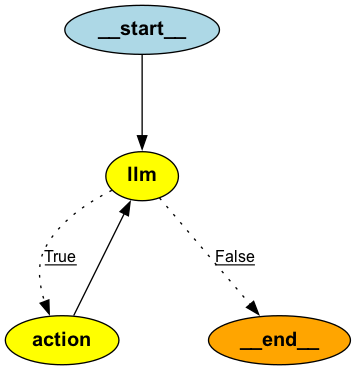

In [28]:
from IPython.display import Image

Image(bot.graph.get_graph().draw_png())

### 💬 Example 1: Retrieval Query (Arduino UNO)  

In this example, the user asks: **“What is Arduino UNO?”**  

- The **Agent** first queries the **VectorDB (`retrieval_tool`)** to check if detailed information about Arduino UNO exists in the local knowledge base.  
- Since Arduino UNO is a common robotics control board, the retrieved documents are sufficient to answer.  
- The Agent then composes the final response directly from the retrieved component datasheet and metadata.  

This demonstrates a **pure retrieval workflow** where the answer is derived entirely from the preprocessed dataset without requiring external search.  

In [122]:
result = bot.graph.invoke({"messages": [HumanMessage(content="What is arduino UNO?")]})

Calling: {'name': 'retrieval_tool', 'args': {'query': 'Arduino UNO'}, 'id': 'call_pZRAApLmNh0qQZtN4mvtsrrv', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'get_location_tool', 'args': {}, 'id': 'call_VRKdanUfDd3WVhK5DPYzfSgV', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'find_product_nearby_tool', 'args': {'component': 'Arduino UNO', 'location': {'city': 'Alexandria', 'country': 'Egypt', 'lat': 31.2000924, 'lon': 29.9187387}}, 'id': 'call_K6wcDwUqGeHJO5y5gXgo8G3w', 'type': 'tool_call'}
Back to the model!


In [123]:
result

{'messages': [HumanMessage(content='What is arduino UNO?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pZRAApLmNh0qQZtN4mvtsrrv', 'function': {'arguments': '{\n  "query": "Arduino UNO"\n}', 'name': 'retrieval_tool'}, 'type': 'function', 'index': 0, 'name': None}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 124, 'prompt_tokens': 1607, 'total_tokens': 1731, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'accounts/fireworks/models/gpt-oss-120b', 'system_fingerprint': None, 'id': '2e7f1776-f677-456c-a3a8-b091292c64fd', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--114bd96a-dfe9-49f3-955f-97bad751b265-0', tool_calls=[{'name': 'retrieval_tool', 'args': {'query': 'Arduino UNO'}, 'id': 'call_pZRAApLmNh0qQZtN4mvtsrrv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1607, 'output_tokens': 124, 'total_tokens': 1731, 'in

In [124]:
result['messages'][-1].content

'**What is an Arduino\u202fUNO?**\n\nThe Arduino\u202fUNO is one of the most popular development boards in the Arduino family. It is designed to be an easy‑to‑use platform for learning electronics, prototyping, and building a wide range of projects—from simple LED blinkers to complex robotics and IoT systems.\n\n| Feature | Details |\n|---------|---------|\n| **Processor (main MCU)** | ATmega328P (8‑bit AVR) running at 16\u202fMHz |\n| **Secondary processor** | ATmega16U2 (handles USB‑to‑serial communication) |\n| **Flash memory** | 32\u202fkB (0.5\u202fkB used by bootloader) |\n| **SRAM** | 2\u202fkB |\n| **EEPROM** | 1\u202fkB |\n| **Operating voltage** | 5\u202fV (USB provides 5\u202fV, VIN accepts 6–20\u202fV) |\n| **Digital I/O pins** | 14 (6 of them PWM‑capable) |\n| **Analog input pins** | 6 (10‑bit ADC) |\n| **Power pins** | VIN, 5\u202fV, 3.3\u202fV, GND, and a reset pin |\n| **USB interface** | Standard Type‑B connector (USB‑C on newer R4 variants) |\n| **Typical uses** | • I

### 🌐 Example 2: Retrieval + Web Search Query  

Now consider a different query: **“Where can I buy Raspberry Pi Pico near me?”**  

- **Step 1:** The Agent queries the **VectorDB** for information about Raspberry Pi Pico specifications.  
- **Step 2:** Since the question involves real-world availability, the Agent invokes the **location tool (`get_location_tool`)** to determine the user’s city and country.  
- **Step 3:** The Agent then calls **`find_product_nearby_tool`**, which uses Google Search (via SerpAPI) plus web scraping to collect local store offers.  
- **Step 4:** The response includes **store name, URL, price, availability, and location**, giving the user actionable purchase options.  

This showcases the **hybrid workflow**: combining structured knowledge retrieval with **live web search and product scraping** to provide both specifications and buying sources.  

In [117]:
result = bot.graph.invoke({"messages": [HumanMessage(content="What are PIC microcontrollers?")]})

Calling: {'name': 'retrieval_tool', 'args': {'query': 'What are PIC microcontrollers?'}, 'id': 'call_RvtzHHs1NIAtBhGhCbIdLJMA', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'get_location_tool', 'args': {}, 'id': 'call_zWoEQFTRXA7ENRrfifBQeSRm', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search', 'args': {'query': 'What are PIC microcontrollers?', 'include_domains': [], 'exclude_domains': [], 'search_depth': 'advanced', 'include_images': False, 'topic': 'general'}, 'id': 'call_cZJM1W90yWpAEfFoiU8qpRPv', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'find_product_nearby_tool', 'args': {'component': 'PIC microcontroller', 'location': {'city': 'Alexandria', 'country': 'Egypt', 'lat': 31.2000924, 'lon': 29.9187387}}, 'id': 'call_3p8verLJOV38aLkMOUSv3tnv', 'type': 'tool_call'}
Back to the model!


In [118]:
result

{'messages': [HumanMessage(content='What are PIC microcontrollers?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RvtzHHs1NIAtBhGhCbIdLJMA', 'function': {'arguments': '{\n  "query": "What are PIC microcontrollers?"\n}', 'name': 'retrieval_tool'}, 'type': 'function', 'index': 0, 'name': None}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 209, 'prompt_tokens': 1588, 'total_tokens': 1797, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'accounts/fireworks/models/gpt-oss-120b', 'system_fingerprint': None, 'id': '571fcea0-b4d1-4f96-acdb-d88cd8a0cda4', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a40fbdee-8ad8-4a87-9e51-44bfebba8ac7-0', tool_calls=[{'name': 'retrieval_tool', 'args': {'query': 'What are PIC microcontrollers?'}, 'id': 'call_RvtzHHs1NIAtBhGhCbIdLJMA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1588,

In [120]:
result["messages"][-1].content

'**What is a PIC microcontroller?**  \n\nA **PIC (Peripheral Interface Controller)** microcontroller is a family of small, low‑power integrated circuits used to run embedded‑system code. They are manufactured by **Microchip Technology** (originally derived from a 1985 General Instrument design).  \n\n| Aspect | Details |\n|--------|---------|\n| **Architecture** | *Harvard* architecture (separate program and data memory) with a *RISC* instruction set, giving fast instruction execution and efficient low‑power operation. |\n| **Word size / families** | • **8‑bit**: PIC10, PIC12, PIC16, PIC18  <br>• **16‑bit**: PIC24, dsPIC33 (digital‑signal‑controller)  <br>• **32‑bit**: PIC32 (MIPS‑core) |\n| **Typical resources** | Flash program memory (from a few\u202fKB up to >1\u202fMB), SRAM (tens to hundreds of bytes), EEPROM or data memory, multiple 8‑bit/16‑bit/32‑bit timers, ADCs, DACs, PWM, USART/UART, SPI, I²C, USB, CAN, and many other peripheral modules. |\n| **Programming** | Usually progra